# Sugestão de cidade do Estado do Rio Grande do Sul pelo Índice de Criminalidade
### Para o trabalho final da disciplina de Sistemas Operacionais foi escolhido os bancos de dados Índice de Criminalidade (RS, 2023) e Estimativas Populacionais (RS, 2022). Os dados são reais e estão disponíveis no portal Dados Abertos RS do Estado do Rio Grande do Sul.
###  O objetivo principal é analisar como o algoritmo k-means irá agrupar as cidades. Com este resultado, será possível responder: "Quais as cidades o algoritmo sugere?". De acordo com a resposta, futuramente seria possível o desenvolvimento de uma aplicação real de sugestão de cidade.

Indíce de Criminalidade no RS: [https://dados.rs.gov.br/dataset/indicadores-criminais-de-2023](https://dados.rs.gov.br/dataset/indicadores-criminais-de-2023)

Estimativas Populacionais no RS: [https://dados.rs.gov.br/dataset/dee-4259/resource/ce259dd9-c479-4a18-90b3-40098e6deb26](https://dados.rs.gov.br/dataset/dee-4259/resource/ce259dd9-c479-4a18-90b3-40098e6deb26)

## Pré-processamento
### Houve a necessidade de realizar o pré-processamento dos dados, pois foram disponibilizados em planilhas Excel com formatações diversas.

In [1]:
import pandas as pd

#### Abertura dos arquivos de criminalidade por cidade em cada mês.

In [2]:
# Lendo os arquivos csv e concatenando em um único dataframe
meses = ['janeiro', 'fevereiro', 'marco', 'abril', 'maio', 'junho', 'julho', 'agosto', 'setembro', 'outubro', 'novembro', 'dezembro']

dfs = []

for mes in meses:
        arquivo = pd.read_csv(f'data\\tocsv\\{mes}.csv', delimiter=';')
        dfs.append(arquivo)

df = pd.concat(dfs, ignore_index=True)

df_criminal = df.groupby(['municipios', 'ibge']).sum().reset_index()


df.to_csv('data\\tocsv\\total.csv', sep=';', index=False)

df_criminal.head()


,municipios,ibge,homicidio_doloso,total_vitimas_homicidio_doloso,latrocinio,furtos,abigeato,furto_veiculo,roubos,roubo_veiculo,estelionato,delitos_armas_municoes,entorpecente_posse,entorpecente_trafico,vitimas_latrocinio,vitimas_lesao_corporal_morte,total_vitimas_crimes_violentos
0,acegua,4300034,0,0,0,20,8,0,3,0,27,4,3,0,0,0,0
1,agua santa,4300059,1,1,0,20,3,4,1,0,13,2,0,0,0,0,2
2,agudo,4300109,1,1,0,102,2,2,3,1,51,3,7,10,0,0,1
3,ajuricaba,4300208,0,0,0,26,1,0,1,0,28,2,3,0,0,0,0
4,alecrim,4300307,1,1,0,36,10,0,2,0,17,10,0,4,0,0,1


#### Abertura do arquivo de quantidade de população por cidade em cada ano.

In [3]:
# Lendo o arquivo de população
df_pop = pd.read_csv('data\\tocsv\\populacao.csv', delimiter=';')

# Substituindo os valores de '.' e '-' por 0 e convertendo para inteiro
for coluna in df_pop.columns[4:]:
    df_pop[coluna] = df_pop[coluna].str.replace('.', '').str.replace('-', '0').astype(int)

df_pop.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   municipios  497 non-null    object 
 1   ibge        497 non-null    int64  
 2   latitude    497 non-null    float64
 3   longitude   497 non-null    float64
 4   2010        497 non-null    int32  
 5   2011        497 non-null    int32  
 6   2012        497 non-null    int32  
 7   2013        497 non-null    int32  
 8   2014        497 non-null    int32  
 9   2015        497 non-null    int32  
 10  2016        497 non-null    int32  
 11  2017        497 non-null    int32  
 12  2018        497 non-null    int32  
 13  2019        497 non-null    int32  
 14  2020        497 non-null    int32  
 15  2021        497 non-null    int32  
dtypes: float64(2), int32(12), int64(1), object(1)
memory usage: 39.0+ KB


### União dos dois banco de dados

In [4]:
# O merge é feito com base na coluna ibge como forma de chave estrangeira com o método inner
df_merged = pd.merge(df_criminal, df_pop, how = 'inner', on = 'ibge').drop(columns=['municipios_y'])
df_merged.rename(columns={'municipios_x': 'municipios'}, inplace=True)

df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 497 entries, 0 to 496
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   municipios                      497 non-null    object 
 1   ibge                            497 non-null    int64  
 2   homicidio_doloso                497 non-null    int64  
 3   total_vitimas_homicidio_doloso  497 non-null    int64  
 4   latrocinio                      497 non-null    int64  
 5   furtos                          497 non-null    int64  
 6   abigeato                        497 non-null    int64  
 7   furto_veiculo                   497 non-null    int64  
 8   roubos                          497 non-null    int64  
 9   roubo_veiculo                   497 non-null    int64  
 10  estelionato                     497 non-null    int64  
 11  delitos_armas_municoes          497 non-null    int64  
 12  entorpecente_posse              497 

### Cálculo da taxa de criminalidade a cada 1000 mil habitantes.
 Para que os dados das grandes cidades, com numerosa população, não tenham impacto nas análises estatísticas, calculasse a taxa de criminalidade percapita. Assim a comparação entre Índice de Criminalidade e População mantém a proporcionalidade.

In [5]:
# Lista das colunas que precisam ser calculadas
colunas_taxa = df_criminal.columns[2:]

# Calculando a taxa de criminalidade para cada mês
for coluna_taxa in colunas_taxa:
    for coluna_pop in df_pop.columns[4:]:
            
            # Calculando a taxa de criminalidade por 100.000 habitantes
            df_merged[f'taxa_{coluna_taxa}'] = df_criminal[coluna_taxa] / df_pop[coluna_pop] * 100000

# Salvando o dataframe em um arquivo csv
df_merged.to_csv('data\\tocsv\\dados_criminalidade_população.csv', sep=';', index=False)

#df_merged.info()


### Normalização dos dados

In [6]:
from sklearn.preprocessing import StandardScaler

In [7]:
# Lista das colunas extras que não são necessárias
colunas_extras = df_merged.columns[2:-15]

# Removendo as colunas extras
df_taxa = df_merged.drop(colunas_extras, axis=1)

df_taxa.set_index('municipios', inplace=True)

# Salvando o dataframe em um arquivo csv
df_taxa.to_csv('data\\tocsv\\dados_taxa_criminalidade.csv', sep=';', index=False)

df_taxa.head()



,ibge,taxa_homicidio_doloso,taxa_total_vitimas_homicidio_doloso,taxa_latrocinio,taxa_furtos,taxa_abigeato,taxa_furto_veiculo,taxa_roubos,taxa_roubo_veiculo,taxa_estelionato,taxa_delitos_armas_municoes,taxa_entorpecente_posse,taxa_entorpecente_trafico,taxa_vitimas_latrocinio,taxa_vitimas_lesao_corporal_morte,taxa_total_vitimas_crimes_violentos
municipios,,,,,,,,,,,,,,,,
acegua,4300034,0.000000,0.000000,0.0,443.951165,177.580466,0.000000,66.592675,0.000000,599.334073,88.790233,66.592675,0.000000,0.0,0.0,0.000000
agua santa,4300059,23.496241,23.496241,0.0,469.924812,70.488722,93.984962,23.496241,0.000000,305.451128,46.992481,0.000000,0.000000,0.0,0.0,46.992481
agudo,4300109,6.019745,6.019745,0.0,614.013966,12.039490,12.039490,18.059234,6.019745,307.006983,18.059234,42.138213,60.197448,0.0,0.0,6.019745
ajuricaba,4300208,0.000000,0.000000,0.0,349.133879,13.428226,0.000000,13.428226,0.000000,375.990332,26.856452,40.284678,0.000000,0.0,0.0,0.000000
alecrim,4300307,15.617679,15.617679,0.0,562.236452,156.176792,0.000000,31.235358,0.000000,265.500547,156.176792,0.000000,62.470717,0.0,0.0,15.617679


In [8]:
# Selecionando somente as colunas do tipo float
df_taxa.drop(['ibge'], axis='columns', inplace=True)

# Normalizando os dados média 0 e desvio padrão 1
scaler = StandardScaler(with_std=True, with_mean=True)
data_scaled = pd.DataFrame(scaler.fit_transform(df_taxa), columns=df_taxa.columns, index=df_taxa.index)

data_scaled.head()

,taxa_homicidio_doloso,taxa_total_vitimas_homicidio_doloso,taxa_latrocinio,taxa_furtos,taxa_abigeato,taxa_furto_veiculo,taxa_roubos,taxa_roubo_veiculo,taxa_estelionato,taxa_delitos_armas_municoes,taxa_entorpecente_posse,taxa_entorpecente_trafico,taxa_vitimas_latrocinio,taxa_vitimas_lesao_corporal_morte,taxa_total_vitimas_crimes_violentos
municipios,,,,,,,,,,,,,,,
acegua,-0.667278,-0.662982,-0.148096,-0.577293,0.767363,-1.069329,0.166330,-0.452223,0.466024,0.248269,-0.355126,-0.849788,-0.148096,-0.118741,-0.734935
agua santa,1.041006,0.952049,-0.148096,-0.517225,-0.070088,1.614715,-0.312287,-0.452223,-0.696525,-0.290999,-0.883722,-0.849788,-0.148096,-0.118741,1.998682
agudo,-0.229615,-0.249211,-0.148096,-0.183993,-0.527157,-0.725502,-0.372669,-0.072440,-0.690371,-0.664292,-0.549240,-0.114174,-0.148096,-0.118741,-0.384758
ajuricaba,-0.667278,-0.662982,-0.148096,-0.796575,-0.516297,-1.069329,-0.424100,-0.452223,-0.417485,-0.550791,-0.563952,-0.849788,-0.148096,-0.118741,-0.734935
alecrim,0.468199,0.410511,-0.148096,-0.303737,0.599988,-1.069329,-0.226339,-0.452223,-0.854563,1.117681,-0.883722,-0.086395,-0.148096,-0.118741,0.173567


## Redução de Dimensionalidade
### O dataset agora tem dados suficientes para ranquear as cidades em mais seguras e não seguras com dados proporcionais a população. Entretanto, existem muitas colunas. A alta dimensionalidade deixará o processo de aprendizado confuso criando um sobreajuste nos dados. Então é aplicado o PCA, uma técnida de redução de dimensionalidade.
### Para fins de demonstração, será usado somente uma amostra de 20 cidades.



In [9]:
# Selecionando 20 linhas aleatórias
df_sample= data_scaled.sample(n=50, axis=0, random_state=42)

df_sample.info()


<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, viadutos to sagrada familia
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   taxa_homicidio_doloso                50 non-null     float64
 1   taxa_total_vitimas_homicidio_doloso  50 non-null     float64
 2   taxa_latrocinio                      50 non-null     float64
 3   taxa_furtos                          50 non-null     float64
 4   taxa_abigeato                        50 non-null     float64
 5   taxa_furto_veiculo                   50 non-null     float64
 6   taxa_roubos                          50 non-null     float64
 7   taxa_roubo_veiculo                   50 non-null     float64
 8   taxa_estelionato                     50 non-null     float64
 9   taxa_delitos_armas_municoes          50 non-null     float64
 10  taxa_entorpecente_posse              50 non-null     float64
 11  taxa_entorpecente_t

In [10]:
import numpy as np

from statsmodels.datasets import get_rdataset
from sklearn.decomposition import PCA


In [11]:
# Aplicando a PCA
pca = PCA()
components = pca.fit_transform(df_sample)

components.shape[1]

15

In [12]:
# Analise de como os componentes estão explicando os dados com a variância explicada
pca.explained_variance_ratio_

array([4.47098635e-01, 2.32033748e-01, 8.44082114e-02, 5.04889539e-02,
       4.27235110e-02, 3.16276294e-02, 2.96811723e-02, 2.64778045e-02,
       2.25440246e-02, 1.69125929e-02, 1.13581028e-02, 2.73685904e-03,
       1.71629956e-03, 1.92455252e-04, 1.22165798e-33])

In [13]:
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go

In [14]:
# Plotando o gráfico da variância explicada acumulada
px.area(
    x=range(1, pca.explained_variance_ratio_.cumsum().shape[0] + 1),
    y=pca.explained_variance_ratio_.cumsum(),
    labels={"x": "Componentes Principais", "y": "Variância Explicada Acumulada"}
)


In [15]:
n = 4

# Aplicando a PCA com n componentes
pca = PCA(n_components=n)
components = pca.fit_transform(df_sample)

components.shape[1]

4

### Dataframe agora utilizando os componentes principais para explicar os dados de criminalidade nas cidades

In [16]:
df_pca = pd.DataFrame(data = components, columns = ['PC1', 'PC2', 'PC3', 'PC4'])
df_pca['municipios'] = df_sample.index
df_pca.set_index('municipios', inplace=True)
df_pca.head()

,PC1,PC2,PC3,PC4
municipios,,,,
viadutos,-0.403146,-1.293090,-0.369115,-0.129705
campos borges,-1.880347,0.920654,-0.470550,0.089534
lajeado,1.997878,-0.197637,1.876114,-0.041748
gaurama,-0.938699,-1.055184,-0.201905,0.941618
macambara,-2.294945,-0.375069,0.391376,0.873373


In [17]:
total_var = pca.explained_variance_ratio_.sum() * 100

fig = px.scatter_matrix(
    df_pca,
    title=f'Taxa Total de Variancia Explicada por 4 PC: {total_var:.2f}%',
    dimensions=df_pca.columns,
    color=df_pca.index,
)
fig.update_traces(diagonal_visible=False)
fig.show()

""" Foi utilizado a biblioteca Plotly para a visualização dos dados. Documentação do gráfico PCA: https://plotly.com/python/pca-visualization/"""

' Foi utilizado a biblioteca Plotly para a visualização dos dados. Documentação do gráfico PCA: https://plotly.com/python/pca-visualization/'

In [18]:
total_var_2 = pca.explained_variance_ratio_[:2].sum() * 100
total_var_2

# Calculando as cargas dos componentes
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Plotando o gráfico de dispersão com os componentes principais
fig = px.scatter(
    components, x=0, y=1, color=df_pca.index,
    labels={'0': 'PC1', '1': 'PC2', 'color': 'Município'},
    title=f'Taxa Total de Variancia Explicada por 2 PC: {total_var_2:.2f}%')

features = df_sample.columns

# Adicionando os vetores de carga ao gráfico
for i, feature in enumerate(features):
    fig.add_annotation(
        ax=0, ay=0,
        axref="x", ayref="y",
        x=loadings[i, 0],
        y=loadings[i, 1],
        showarrow=True,
        arrowsize=2,
        arrowhead=2,
        xanchor="right",
        yanchor="top"
    )
    
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
        yshift=5,
    )
# Invertendo o eixo y para que o gráfico fique na posição correta    
fig.update_yaxes(autorange="reversed")
fig.show()

""" Foi utilizado a biblioteca Plotly para a visualização dos dados. Documentação do gráfico PCA: https://plotly.com/python/pca-visualization/"""

' Foi utilizado a biblioteca Plotly para a visualização dos dados. Documentação do gráfico PCA: https://plotly.com/python/pca-visualization/'

In [19]:
""" i, j = 0, 1 # which components
scale_arrow = s_ = 2
components[:,1] *= -1
pca.components_[1] *= -1 # flip the y-axis
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.scatter(components[:,0], components[:,1])
ax.set_xlabel('PC%d' % (i+1))
ax.set_ylabel('PC%d' % (j+1))
for k in range(pca.components_.shape[1]):
    ax.arrow(0, 0, s_*pca.components_[i,k], s_*pca.components_[j,k])
    ax.text(s_*pca.components_[i,k],
            s_*pca.components_[j,k],
            df_sample.columns[k]) """

" i, j = 0, 1 # which components\nscale_arrow = s_ = 2\ncomponents[:,1] *= -1\npca.components_[1] *= -1 # flip the y-axis\nfig, ax = plt.subplots(1, 1, figsize=(8, 8))\nax.scatter(components[:,0], components[:,1])\nax.set_xlabel('PC%d' % (i+1))\nax.set_ylabel('PC%d' % (j+1))\nfor k in range(pca.components_.shape[1]):\n    ax.arrow(0, 0, s_*pca.components_[i,k], s_*pca.components_[j,k])\n    ax.text(s_*pca.components_[i,k],\n            s_*pca.components_[j,k],\n            df_sample.columns[k]) "

## K-means com dados brutos de taxa

In [20]:
from sklearn import cluster

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
# Aplicando o método de Elbow para encontrar o número de clusters
clusters = np.arange(1,10,1)

SSE = []
for k in clusters:
    k_means = cluster.KMeans(n_clusters=k, init='k-means++', n_init=25, max_iter=300 , random_state=42)
    k_means.fit(df_sample)
    SSE.append(k_means.inertia_)

SSE

[715.578611336438,
 466.11205480452367,
 354.245706296042,
 306.8649564752308,
 275.67409058476125,
 243.95647656820728,
 226.28176970536217,
 200.66658221421739,
 188.08711234826194]

Text(0, 0.5, 'SSE')

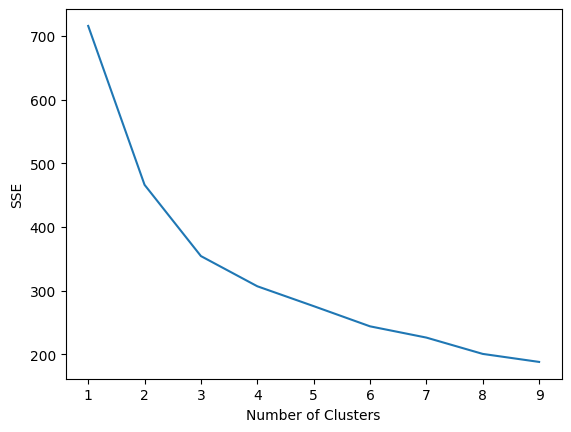

In [23]:
# Plotando o gráfico do método de Elbow
plt.plot(clusters, SSE)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

In [24]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [25]:
# Aplicando o método de Silhouette para encontrar o número de clusters
clusters = np.arange(2,17,1)
SC = []
for k in clusters:
    k_means = cluster.KMeans(n_clusters=k, init='k-means++', n_init=25, max_iter=300, random_state=42)
    k_means.fit(df_sample)
    SC.append(silhouette_score(df_sample, k_means.labels_))
SC

[0.39918478833505716,
 0.38001569953135295,
 0.3509412860953289,
 0.21339861177218247,
 0.23134942133687467,
 0.21272691529215862,
 0.21953415498184525,
 0.14184395722778992,
 0.1732350339957565,
 0.17193499280061722,
 0.1861130012023671,
 0.1534103474685473,
 0.14241824655357402,
 0.15620928212203028,
 0.15688722425026908]

Text(0, 0.5, 'SC')

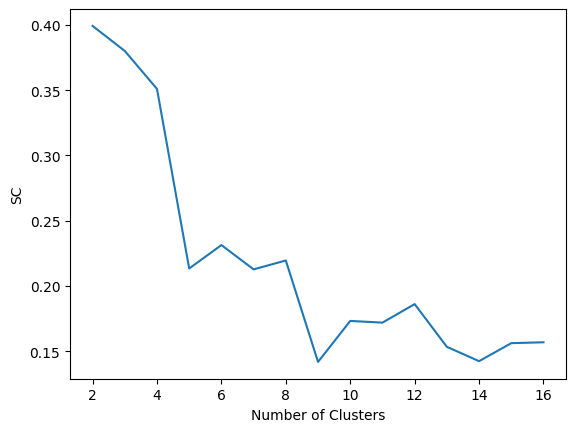

In [26]:
# Plotando o gráfico do método de Silhouette
plt.plot(clusters, SC)
plt.xlabel('Number of Clusters')
plt.ylabel('SC')

In [27]:
k = 2

# Aplicando o KMeans com k clusters
k_means = cluster.KMeans(n_clusters=k, init='k-means++', n_init=25, max_iter=300, random_state=42)
k_means.fit(df_sample)

KMeans(n_clusters=2, n_init=25, random_state=42)

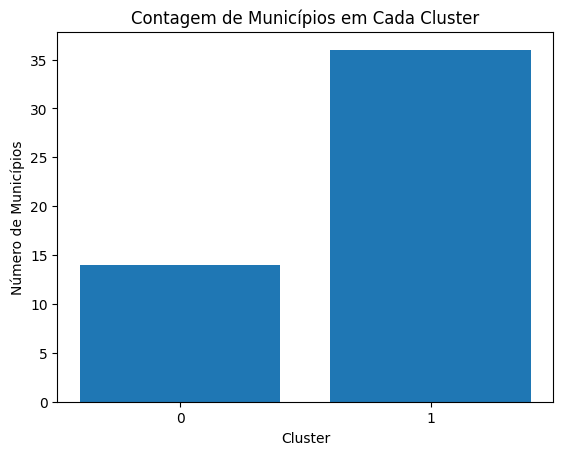

In [28]:
# Contar a ocorrência de cada cluster
contagem = np.bincount(k_means.labels_)

# Plotar o gráfico de barras
plt.bar(range(len(contagem)), np.sort(contagem), tick_label=range(len(contagem)))
plt.xlabel('Cluster')
plt.ylabel('Número de Municípios')
plt.title('Contagem de Municípios em Cada Cluster')
plt.show()

## K-means com PCA

In [29]:
# Aplicando o método de Elbow para encontrar o número de clusters
clusters = np.arange(1,15,1)

SSE = []
for k in clusters:
    k_means = cluster.KMeans(n_clusters=k, init='k-means++', n_init=25, max_iter=300, random_state=42)
    k_means.fit(df_pca)
    SSE.append(k_means.inertia_)

SSE

[582.5021339841612,
 333.7085388602998,
 222.79993994639702,
 176.72351785165563,
 150.13416290882685,
 127.03455819155009,
 106.2412547461585,
 92.61655383969811,
 81.60954861353399,
 70.31455508427152,
 62.327585655193765,
 54.13070463491001,
 49.94542221648783,
 42.673611394202275]

Text(0, 0.5, 'SSE')

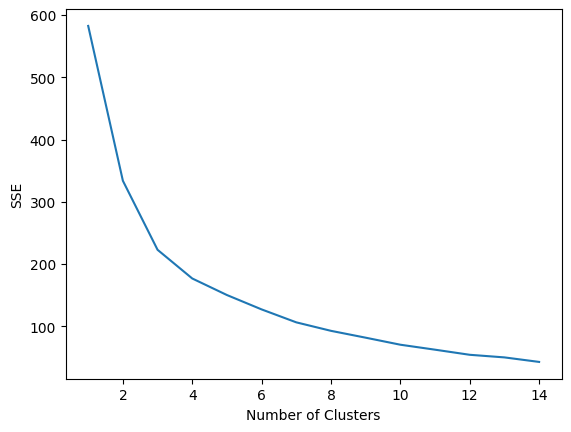

In [30]:
# Plotando o gráfico do método de Elbow
plt.plot(clusters, SSE)
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')

In [31]:
# Aplicando o método de Silhouette para encontrar o número de clusters
clusters = np.arange(2,14,1)
SC = []
for k in clusters:
    k_means = cluster.KMeans(n_clusters=k, init='k-means++', n_init=25, random_state=123)
    k_means.fit(df_pca)
    SC.append(silhouette_score(df_pca, k_means.labels_))
SC

[0.47744196206251,
 0.4767801401773442,
 0.45180399974635704,
 0.3495958137411752,
 0.35971612228365374,
 0.3694917319139911,
 0.28364876803976335,
 0.23555793276565878,
 0.2898805767884477,
 0.288348220773209,
 0.25859736866527805,
 0.2645716249193012]

Text(0, 0.5, 'SC')

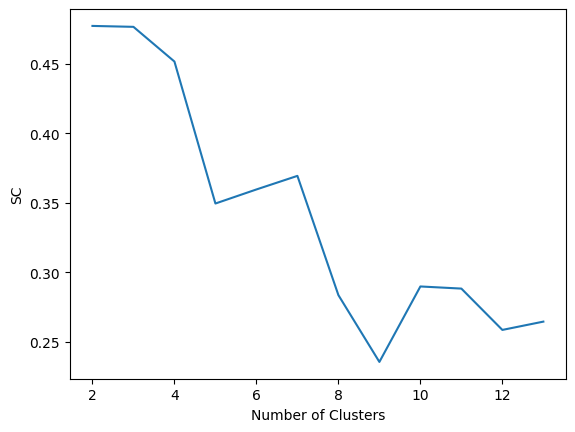

In [32]:
# Plotando o gráfico do método de Silhouette
plt.plot(clusters, SC)
plt.xlabel('Number of Clusters')
plt.ylabel('SC')

In [33]:
k = 3

# Aplicando o KMeans com n clusters
k_means = cluster.KMeans(n_clusters=k, init='k-means++', n_init=25, random_state=123)
k_means.fit(df_pca)

KMeans(n_clusters=3, n_init=25, random_state=123)

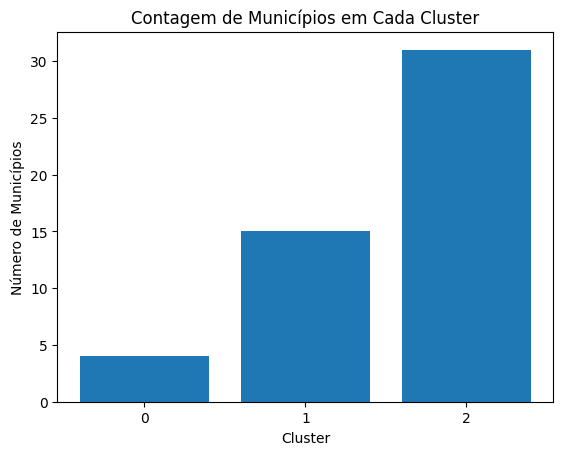

In [34]:
# Plotar o gráfico de barras para contagem de municípios em cada cluster

# Contar a ocorrência de cada cluster
contagem = np.bincount(k_means.labels_)

plt.bar(range(len(contagem)), np.sort(contagem), tick_label=range(len(contagem)))
plt.xlabel('Cluster')
plt.ylabel('Número de Municípios')
plt.title('Contagem de Municípios em Cada Cluster')
plt.show()

In [35]:
# Salvando os clusters no dataframe
labels = k_means.labels_
df_pca['cluster'] = labels

# Salvando o dataframe em um arquivo csv
df_pca.to_csv('data\\tocsv\\clusterizado.csv', sep=',', index=False)

df_pca.head()

,PC1,PC2,PC3,PC4,cluster
municipios,,,,,
viadutos,-0.403146,-1.293090,-0.369115,-0.129705,0
campos borges,-1.880347,0.920654,-0.470550,0.089534,0
lajeado,1.997878,-0.197637,1.876114,-0.041748,1
gaurama,-0.938699,-1.055184,-0.201905,0.941618,0
macambara,-2.294945,-0.375069,0.391376,0.873373,0


In [36]:
# Criar o gráfico 3D
fig = go.Figure()

# Adicionar os pontos
fig.add_trace(
    go.Scatter3d(
        # Adicionar as dimensões PCA
        x=df_pca['PC1'],
        y=df_pca['PC2'],
        z=df_pca['PC3'],
        mode='markers',
        # Adicionar a cor de acordo com o cluster
        marker=dict(size=5, color=df_pca['cluster'], colorscale='magenta', opacity=0.8),
        # Adicionar o nome dos município ao passar o mouse
        text=df['municipios']
))

# Adicionar o layout
fig.update_layout(
    title=f'Gráfico 3D dos {k} Clusters',
    # Adicionar o nome dos eixos
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    )
)

# Mostrar o gráfico
fig.show()

""" Foi utilizado a biblioteca Plotly para a visualização dos dados. Documentação do gráfico 3D: https://plotly.com/python/v3/3d-point-clustering/"""

' Foi utilizado a biblioteca Plotly para a visualização dos dados. Documentação do gráfico 3D: https://plotly.com/python/v3/3d-point-clustering/'